In [1]:
import sys ###q5header
sys.path.append('../scripts/')
from dp_policy_agent import *
import random, copy #copy追加

In [2]:
class StateInfo: #q4stateinfo
    def __init__(self, action_num, epsilon=0.3):
        self.q = np.zeros(action_num)
        self.epsilon = epsilon
        
    def greedy(self):
        return np.argmax(self.q)
    
    def epsilon_greedy(self, epsilon): 
        if random.random() < epsilon:
            return random.choice(range(len(self.q)))
        else:
            return self.greedy()
    
    def pi(self):
        return self.epsilon_greedy(self.epsilon) 
    
    def max_q(self):              #追加
        return max(self.q)

In [3]:
class QAgent(PuddleIgnoreAgent): ###qagent4init（1〜4, 19〜23行目）
    def __init__(self, time_interval, particle_pose, envmap, puddle_coef=100, alpha=0.5, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T):   #alpha追加
 
        super().__init__(time_interval, particle_pose, envmap, None, puddle_coef, motion_noise_stds)
        
        ###DynamicProgrammingから持ってくる###
        self.pose_min = np.r_[lowerleft, 0]
        self.pose_max = np.r_[upperright, math.pi*2]
        self.widths = widths
        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int)
        nx, ny, nt = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt)))
        
        ###PuddleIgnorePolicyの方策と価値関数の読み込み###
        self.actions, self.ss = self.set_action_value_function()
        
        ###強化学習用変数### #追加
        self.alpha = alpha
        self.s, self.a = None, None
        self.update_end = False

    def set_action_value_function(self): 
        policy = np.zeros(np.r_[self.index_nums,2])
        for line in open("puddle_ignore_policy.txt", "r"): 
            d = line.split()
            policy[int(d[0]), int(d[1]), int(d[2])] = [float(d[3]), float(d[4])]
        
        actions = list(set([tuple(policy[i]) for i in self.indexes])) 
        action_num = len(actions)
        
        ss = {}
        for line in open("puddle_ignore_values.txt", "r"): 
            d = line.split()
            index, value = (int(d[0]), int(d[1]), int(d[2])), float(d[3]) 
            ss[index] = StateInfo(action_num) 
            
            for i, a in enumerate(actions): 
                ss[index].q[i] = value if tuple(policy[index]) == a else value - 0.1
                
        return actions, ss
    
    def policy(self, pose): ###q4policy
        index = np.floor((pose - self.pose_min)/self.widths).astype(int)
        
        index[2] = (index[2] + self.index_nums[2]*1000)%self.index_nums[2]
        for i in [0,1]:
            if index[i] < 0: index[i] = 0
            elif index[i] >= self.index_nums[i]: index[i] = self.index_nums[i] - 1
                
        s = tuple(index)          #Q学習の式で使う記号に変更
        a = self.ss[s].pi()
        return s, a                 #行動は値でなくインデックスで返す
            
    def decision(self, observation=None):###q4decision
        ###終了処理###
        if self.update_end:
            return 0.0, 0.0
        if self.in_goal:
            self.update_end = True #ゴールに入った後も一回だけ更新があるので即終了はしない
        
        ###カルマンフィルタの実行###
        self.kf.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.kf.observation_update(observation)
        
        ###行動決定と報酬の処理###
        s_, a_ = self.policy(self.kf.belief.mean) #KFの結果から前回の状態遷移のs'と次の行動a_（max_a'のa'ではないことに注意）を得る
        r = self.time_interval*self.reward_per_sec() #状態遷移の報酬
        self.total_reward += r
        
        ###Q学習と現在の状態と行動の保存###
        self.q_update(r, s_)      #前にいた状態、とった行動に対する価値を更新
        self.s, self.a = s_, a_

        ###出力###
        self.prev_nu, self.prev_omega = self.actions[a_]
        return self.actions[a_]

    def q_update(self, r, s_):###q4update
        if self.s == None:
            return
        
        q = self.ss[self.s].q[self.a]
        q_ = self.final_value if self.in_goal else self.ss[s_].max_q()
        self.ss[self.s].q[self.a] = (1.0 - self.alpha)*q + self.alpha*(r + q_)

In [4]:
class WarpRobot(Robot): ###q5warprobot
    def __init__(self, *args, **kwargs): 
        super().__init__(*args, **kwargs)
        
        self.init_agent = copy.deepcopy(self.agent) #エージェントのコピーを残しておく
        
    def choose_pose(self):  #初期位置をランダムに決めるメソッド（雑）
        xy = random.random()*8-4
        t = random.random()*2*math.pi
        return np.array([4, xy, t]).T if random.random() > 0.5 else np.array([xy, 4, t]).T
        
    def reset(self):
        #ssだけ残してエージェントを初期化
        tmp = self.agent.ss
        self.agent = copy.deepcopy(self.init_agent)
        self.agent.ss  = tmp
        
        #初期位置をセット（ロボット、カルマンフィルタ）
        self.pose = self.choose_pose()
        self.agent.kf.belief = multivariate_normal(mean=self.pose, cov=np.diag([1e-10, 1e-10, 1e-10]))
        
        #軌跡の黒い線が残らないように消す
        self.poses = []
    
    def one_step(self, time_interval):
        if self.agent.update_end:
            with open("log.txt", "a") as f:
                f.write("{}\n".format(self.agent.total_reward + self.agent.final_value))
            self.reset()
            return
        
        super().one_step(time_interval)

<IPython.core.display.Javascript object>


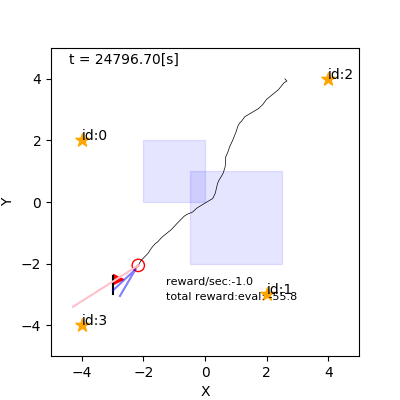

In [5]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = PuddleWorld(400000000, time_interval) #時間をほぼ無限に

    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(4,4))
    m.append_landmark(Landmark(-4,-4))
    world.append(m)
    
    ###ゴールの追加###
    goal = Goal(-3,-3)
    world.append(goal)
    
    ###水たまりの追加###
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1))

    ###ロボットを1台登場させる###
    init_pose = np.array([3, 3, 0]).T
    qa = QAgent(time_interval, init_pose, m)
    r = WarpRobot(init_pose, sensor=Camera(m, distance_bias_rate_stddev=0, direction_bias_stddev=0), 
              agent=qa, color="red", bias_rate_stds=(0,0))

    world.append(r)
    
    world.draw()
    #r.one_step(0.1) #デバッグ時

<IPython.core.display.Javascript object>


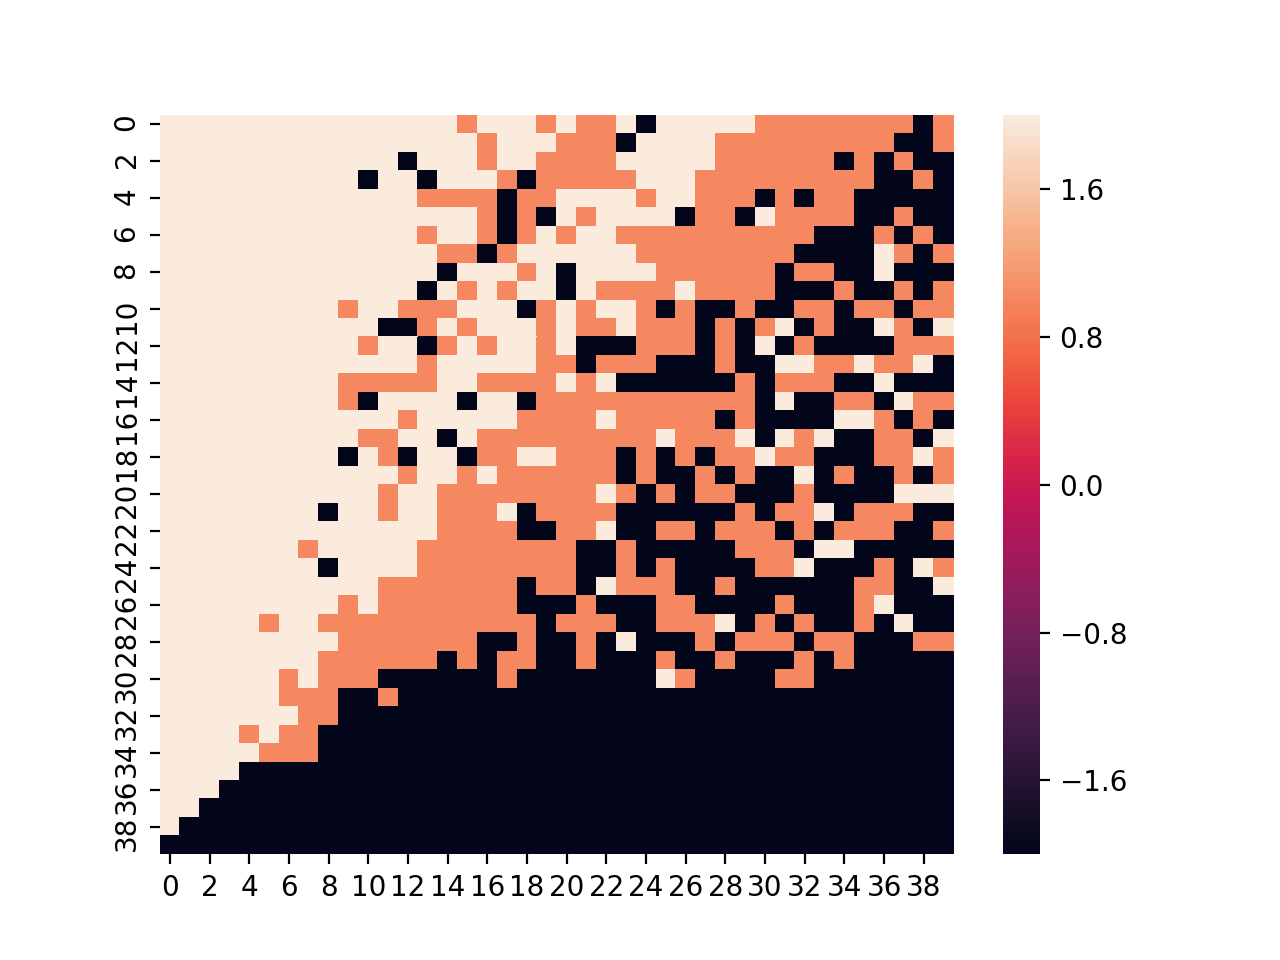

In [17]:
p = np.zeros(qa.index_nums[0:2])
for x in range(qa.index_nums[0]):
    for y in range(qa.index_nums[1]):
        a = qa.ss[(x,y,22)].greedy()
        p[x,y] = qa.actions[a][0] + qa.actions[a][1]
        
import seaborn as sns   
sns.heatmap(np.rot90(p), square=False)
plt.show()

<IPython.core.display.Javascript object>


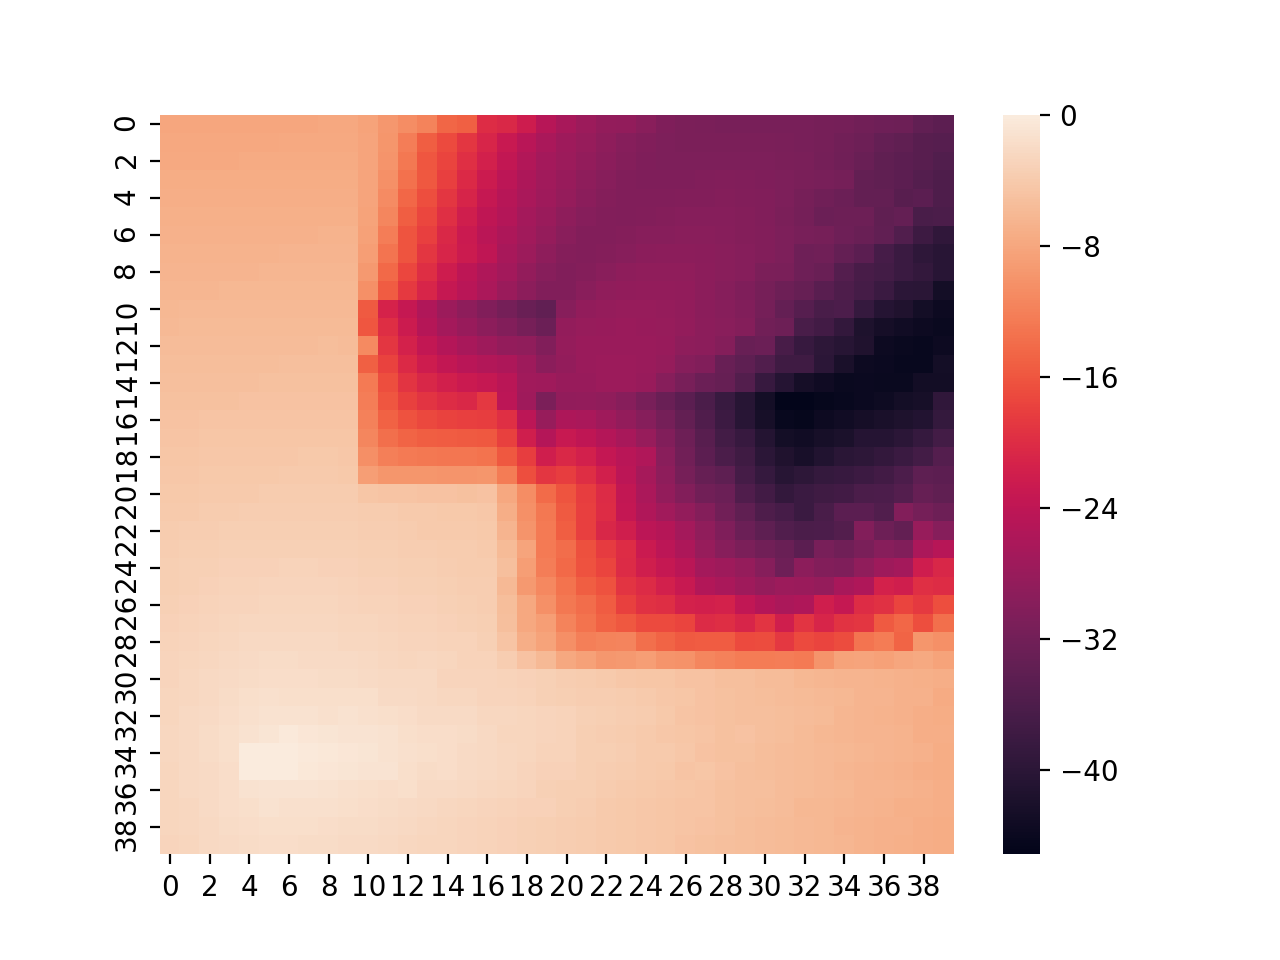

In [25]:
v = np.zeros(r.agent.index_nums[0:2])
for x in range(r.agent.index_nums[0]):
    for y in range(r.agent.index_nums[1]):
        v[x,y] = r.agent.ss[(x,y,18)].max_q()
        
import seaborn as sns   
sns.heatmap(np.rot90(v), square=False)
plt.show()

In [24]:
with open("policy20000.txt", "w") as f:  ###
    for index in qa.indexes:
        p = qa.actions[qa.ss[index].greedy()]
        f.write("{} {} {} {} {}\n".format(index[0], index[1], index[2], p[0], p[1]))